#**TF-IDF and LinearModel**(part 1)


Для начала можно использовать TFIDF и линейную регрессию:

Импортируем нужные библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

Скачиваем данные

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_first_step_in_nlp/main/datasets/salary_data_cleaned.csv")

Можно посмотреть на данные с которыми мы будем работать. Целевой переменной будет "avg_salary".


(742, 28)


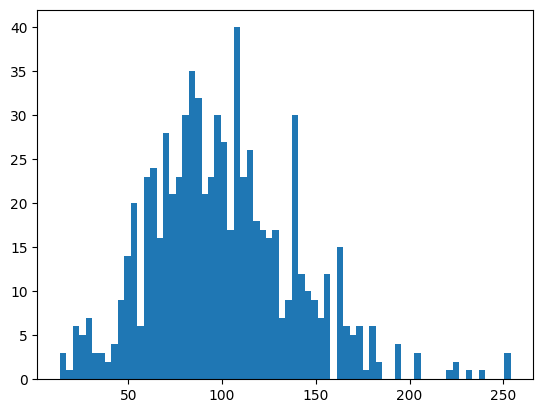

In [ ]:
print(df.shape)#количество строк и столбцов
df['avg_salary'].describe()#описательная статистика
plt.hist(df['avg_salary'], bins = 70)#график распределения
plt.show()

**Векторизация** переменной *Job Description* с помощью метода **TF-IDF**

In [ ]:
tfidf = TfidfVectorizer(min_df = 5, max_df=1.0, ngram_range=(1,1))
X = tfidf.fit_transform(df['Job Description'])
X

<742x4640 sparse matrix of type '<class 'numpy.float64'>'
	with 203494 stored elements in Compressed Sparse Row format>

Получилась разреженная матрица(то есть с большим количеством нулей)

Разделим данные на тренировочные и тестовые

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df["avg_salary"], test_size=0.2, random_state=42)

Обучаем модель и вычисляем R^2

In [ ]:
model = Ridge(alpha=1.1)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print(r2_score(Y_test, predictions))
print(cross_val_score(model,X, df['avg_salary'], cv=5, scoring='r2').mean())

0.6191311743257972
0.5511281006370048


Посчитана кросс-валидация и точность модели стала сильно меньше.

Можно также посмотреть, как влияют некоторые слова на заработную плату

In [ ]:
coefs = sorted(zip(list(np.array(tfidf.get_feature_names_out())[model.coef_ != 0]), model.coef_[model.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])
coefs

,ngram,weight
0,actuarial,36.893315
1,platform,36.890454
2,credit,35.609417
3,climate,35.009046
4,predictive,33.149911
...,...,...
4635,hospital,-29.456601
4636,reporting,-31.522382
4637,marketing,-32.557034
4638,environmental,-34.053000


Результат точности модели не очень высокий, поэтому, можно попробовать сделать более серьёзную **предобработку текста**, а также применить **нейронные сети**.

# Using **MLP**(Multilayer Perceptron) and text preprocessing

Импортируется библиотеки для обработки текста.
Написана функция, которая удаляет "стоп-слова", и знаки пунктуации, так как ничего из этого не несет информационной ценности. Текст также пройдет лемматизацию.
Импортируется нейронная сеть которая представляет из себя многослойный персептрон. Также испольльзуется инструмент под названием GridSearchCV - это  инструмент для подбора гиперпараметров модели с использованием перекрестной проверки (cross-validation).

In [ ]:
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if not token in stop_words and not token in string.punctuation and not token == '’' and not token == '•']
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens
def join(text):
    return ' '.join(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['Job Description'] = df['Job Description'].apply(preprocess_text)

In [ ]:
df['Job Description'] = df['Job Description'].apply(join)

In [ ]:
tfidf = TfidfVectorizer(min_df = 5, max_df=1.0, ngram_range=(1,1))
X = tfidf.fit_transform(df['Job Description'])
X

<742x4106 sparse matrix of type '<class 'numpy.float64'>'
	with 172697 stored elements in Compressed Sparse Row format>

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df["avg_salary"], test_size=0.2, random_state=42)

In [ ]:
mlp = MLPRegressor()
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

grid_search = GridSearchCV(mlp, param_grid = parameters, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
# 0.6615244511214486
# {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'sgd'} - подобранные параметры

Эта часть кода отвечает за подбор гиперпараметров.

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(50), activation='relu', solver='sgd', max_iter=500)
mlp.fit(X_train, Y_train)
predictions = mlp.predict(X_test)
# Оценка качества модели
score = r2_score(Y_test, predictions)
print('Score:', score)
#Score: 0.826932403271288
# scores = cross_val_score(mlp, X, df['avg_salary'], cv=5, scoring='r2')
# print('R2-score:', scores)
# # R2-score: [0.39444059 0.46848431 0.8851489  0.87579443 0.73198845]
# scores.mean()
# 0.6711713343113992


Тут происходит тренировка модели. Изначально точность довольно высокая, но при использовании кросс-валидации, она уменьшается. Однако результат сильно больше чем при использовании линейной модели. На линейной модели результат был 0.55 а тут 0.67.

Нужно отметить, что количество текста, на котором обучалась модель довольно небольшое, и, в таком случае, не рекомендуется использовать нейронные сети. Однако, так как идет работа со словами, и возможны нелинейные зависимости, то использование нейросети допускается.